# Code example 1: Extracting embeddings

<a href="https://colab.research.google.com/github/BioGeMT/MALTAomics-Summer-School/blob/main/Day4_WorkshopVII_DeepLearningForProteinStructure/maltaomics_ex1_embedding_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets

In [2]:
HF_DATASET_NAME_IN = 'roa7n/maltaomics_dataset_clustered'
HF_DATASET_NAME_OUT = 'roa7n/maltaomics_dataset_embeddings'
HF_MODEL_NAME = 'Rostlab/prot_bert_bfd'

Use GPU if possible:

In [3]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [4]:
!nvidia-smi

Wed Sep 13 20:44:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


## 1. Load the Dataset:

Load the dataset:

In [6]:
from datasets import Dataset, load_dataset

dss = load_dataset(HF_DATASET_NAME_IN)
dss

DatasetDict({
    train: Dataset({
        features: ['seq', 'label'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['seq', 'label'],
        num_rows: 400
    })
})

## 2. Load the Model and Tokenizer:

In [7]:
import torch
from transformers import AutoTokenizer, AutoModel, pipeline

tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME, do_lower_case=False)
tokenizer

BertTokenizerFast(name_or_path='Rostlab/prot_bert_bfd', vocab_size=30, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [8]:
model = AutoModel.from_pretrained(HF_MODEL_NAME)
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-29): 30 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inpla

## 3. Extract embeddings from ProtBert-BFD:

Use a `feature-extraction` pipeline to extract the embeddings:

In [9]:
fe = pipeline('feature-extraction', model=model, tokenizer=tokenizer, device=0)
fe

In [10]:
test_string = 'DENCA'

def preprocess_string(seq_str):
  return ' '.join(list(seq_str))

preprocess_string(test_string)

'D E N C A'

In [11]:
import numpy as np
import skimage.measure

def get_embedding(seq):
  embedding = fe(seq)
  features =  np.array(embedding[0][1:len(seq)+1])
  features = skimage.measure.block_reduce(features, (1024, 1), np.average)
  return {'features': np.array(features[0], dtype=float).tolist()}

len(get_embedding(preprocess_string(test_string))['features'])

1024

Get embeddings for our entire dataset (takes ~5 minutes):

In [12]:
dss = dss.map(lambda sample: get_embedding(preprocess_string(sample['seq'])))
dss

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['seq', 'label', 'features'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['seq', 'label', 'features'],
        num_rows: 400
    })
})

Have a closer look at the embedding for 1 actual protein:

In [13]:
len(dss['train'][0]['features'])

1024

In [14]:
dss['train'][0]['features']

[0.01041024891685538,
 -0.010101161301804495,
 0.00940462646906326,
 -0.014151807702972974,
 0.0011759218975413432,
 0.0035883107441634365,
 -0.006641884185256686,
 -0.0033023639552425266,
 0.006058165511831248,
 -0.0026734030769581807,
 0.007594230043919126,
 -8.088583641807645e-05,
 0.0049398033223155835,
 0.0123336797015412,
 -0.008610214968086893,
 0.00727992649251874,
 -0.004527404211088992,
 0.010956445918871793,
 0.005000236764431065,
 0.07121701315054452,
 -0.0006453876919394474,
 -0.0037538251200714967,
 -0.01173084245078826,
 -0.002348230002951368,
 -0.0077286425453664265,
 0.007246544813966693,
 0.007554783421170441,
 0.004734591761689444,
 0.0031595387910243744,
 0.004045796426595416,
 0.0039077877042519304,
 -0.003587793884527457,
 0.001958897809061,
 0.004844097775233536,
 -0.0049773981728833405,
 0.009188889654769383,
 -0.046960614960397606,
 -0.011482707782874968,
 0.0017960634956040167,
 0.008682347644706878,
 -0.006044518797324372,
 -0.001293762874922777,
 0.007105658

## 4. Prepare the Dataset for ML:

Normalize the embeddings:

In [15]:
import pandas as pd

df_train = pd.DataFrame(dss['train'])
df_test = pd.DataFrame(dss['test'])
df_test

,seq,label,features
0,MKILVCLKQILDPEVSPRDFQVDPDRLEAVLGSASLVTNIFCENAL...,0,"[-0.001673037943135114, -0.007994170979024773,..."
1,MSIIPDLLLLLSLVIYLVVRVKQKQPVDLKVLVIWLGLSLLLDTGI...,0,"[-0.007835094343970894, -0.01180256348892783, ..."
2,MKLRFIWPGKTKDEHLRALVTEYLKRLQRFVRCEVIETRGVAGSNP...,1,"[-0.0007489768387642926, -0.001591798125900823..."
3,MPAERVLVGYVDDRRGADAVALAACAASEPGTELVLGHIRIDAWPD...,0,"[0.001701812636952127, -0.006498380971805773, ..."
4,MKKNPAAEPIYPADKIMGLADAIDWRERLRRQGKRLAVTNGCFDIL...,0,"[0.004938519848622036, -0.004270518468615592, ..."
...,...,...,...
395,MPIIYIDSLDHPGVDIFYALTEAQLRNKQHSDKGLFIAESPKVIEV...,1,"[-0.0018363367888696303, -0.004562263703434155..."
396,MRPGEAPFTERTPRVAAARALLRRQGRERAGRFLAEGPQAVGEAVG...,1,"[0.01342363320108575, -0.012741954989063053, 0..."
397,MNRRECLNECEEIRKSEVDRKFDLITRNLKEVVGGDRIKPILENRD...,0,"[0.01941005889264602, 0.00428727048117139, 0.0..."
398,MTEVKNILVALDLTNIDDTLINYTSFISELLGAEKVYFVHNIKKYE...,0,"[-0.003452673845544041, 0.000501893857176583, ..."


In [16]:
def split_features_to_columns(df):
  df['features'] = df['features'].apply(lambda row: str(row).replace('[', '').replace(']', '').replace(',', ''))
  return df['features'].str.split(' ', expand=True)

df_train_features = split_features_to_columns(df_train)
df_test_features = split_features_to_columns(df_test)
df_test_features

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-0.001673037943135114,-0.007994170979024773,0.0029814215386636533,0.002345486535659802,0.0013222304156244036,0.0028004377259094326,-0.004415225880364915,-0.000254687058642844,-0.006590554610738764,-0.0035537726388525925,...,0.002296357003956473,-0.014696607184532695,-0.004843161560415865,-0.0042617481357751785,-0.014370448894396759,0.00350678915788194,-0.005827260253113309,-0.0032577815317935688,-0.007198691012916925,0.0036519996595814064
1,-0.007835094343970894,-0.01180256348892783,-0.0007591115083442901,0.009300872745740207,-0.0038279680881601053,-0.0027246522294781528,0.005206498425494033,-0.004055784393628414,-0.006410353240767108,0.021716591660123186,...,0.007360965830002897,-0.020498775312262296,-0.005007886425271835,-0.011659074968633831,-0.008998039873915786,-0.011623030277018387,0.00708722683506835,0.0010140007478840474,-0.006689709410231615,-0.0057904022989987425
2,-0.0007489768387642926,-0.001591798125900823,-0.003993070220587924,-0.0021171111058464476,0.006686496334992853,0.005879989135678443,-0.0005517192260380277,-0.005850431921160748,0.0016983444951961246,0.003045980612967014,...,0.006812697328996364,-0.004068740067964427,-0.0035560268331575884,-0.0029992460879384453,-0.01143107581006575,0.0005960954023151999,-0.0033415582433917734,-0.000299922942019748,-0.001381230517097265,0.003309069254783026
3,0.001701812636952127,-0.006498380971805773,0.005775353511914716,-0.011960000002048332,0.0028207436341176617,0.009863709957187439,-0.002727276181332172,-0.010911577939296535,-0.00267719575758818,-0.005609707612904913,...,-0.0021706074131202513,-0.01399374593412972,-0.012638709310980545,-0.004788064977386597,-0.00123372148971157,-0.0047865611877142555,-0.006521815951856524,0.004835031327750983,-0.006442602614754378,0.0022831792614255164
4,0.004938519848622036,-0.004270518468615592,-0.0015685435971590778,-0.0023280085145245266,0.005184932388715424,0.0003338428712709174,-0.00130285254294904,-0.0057792374698379945,-9.01971637006227e-05,-0.003068284964456325,...,0.0025297934781747244,-0.0024440077100535973,-0.006372738109007514,-0.004773995271250442,-0.006648138380114688,-0.0035173044869907244,-0.0032088213246197483,-0.001587325330390854,-0.000171004710523448,-8.244232952847597e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.0018363367888696303,-0.004562263703434155,-0.005265823250226731,0.0003247625036806312,0.007600786580496788,0.005564429009751848,-0.0038732429605659036,-0.002163737168075386,0.0016592935802250963,0.0013570649079293062,...,0.005229242463332895,-0.022416513028701957,-0.004524460473618319,-0.0025739834574238785,-0.0167406663326517,-0.0008298942936448839,-0.011556232274287481,-0.004525901340116434,-0.01110885447396015,5.5944832141108236e-05
396,0.01342363320108575,-0.012741954989063053,0.006686540397339513,-0.006324588943257936,-0.005335535166310024,-0.0008615552653452596,-0.010901284383493248,-0.015803074636949077,-0.0014001370579705963,-0.012124417874218807,...,-0.00022506243854536478,-0.018557353915809927,-0.015548522108019824,-0.003128293336999377,-0.02590853398805848,-0.004509428373836499,0.002316743545350164,-3.157116177021635e-05,0.001219260487069107,0.00342264359528599
397,0.01941005889264602,0.00428727048117139,0.004479315909918569,-0.002404681834732969,0.0013235017060821974,0.0029882704629500267,-0.00509646590805346,0.0006338731677146825,0.008548130673517562,-0.0023486151144469503,...,0.009733170777394662,-0.01456279401224947,-0.001132829615215769,-0.00017106863143112605,-0.005849598357485775,-0.011090023051707476,-0.008191663351908574,-0.0037248346784473085,-0.005623366085174553,0.0006677724683754604
398,-0.003452673845544041,0.000501893857176583,-0.0014440100458941174,-0.00010513607405471248,0.001108417847371257,0.004616112130817029,0.011546993642440384,-0.002788850014486144,-0.007919002235524886,0.01600203677642753,...,0.004872535290104452,-0.0054729040175516275,-0.00531

In [17]:
from sklearn import preprocessing

def normalize_features(df_features):
  x = df_features.values # returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
  x_scaled = min_max_scaler.fit_transform(x)
  return pd.DataFrame(x_scaled)

df_train_normalized = normalize_features(df_train_features)
df_test_normalized = normalize_features(df_test_features)
df_test_normalized

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.432511,0.370168,0.633335,0.375320,0.191104,0.661021,0.564127,0.492131,0.412237,0.243448,...,0.457958,0.755466,0.768368,0.409629,0.260048,0.816303,0.666299,0.455434,0.510167,0.407617
1,0.313559,0.276072,0.539772,0.476926,0.116401,0.464621,0.738672,0.416493,0.417307,0.523519,...,0.551453,0.671362,0.765160,0.227835,0.300963,0.579534,0.856995,0.557308,0.522219,0.161679
2,0.450349,0.528355,0.458879,0.310129,0.268913,0.770490,0.634214,0.380781,0.645427,0.316593,...,0.541332,0.909518,0.793434,0.440656,0.282434,0.770753,0.703003,0.525974,0.647922,0.398685
3,0.497658,0.407125,0.703221,0.166342,0.212840,0.912099,0.594748,0.280069,0.522331,0.220662,...,0.375495,0.765654,0.616556,0.396695,0.360094,0.686519,0.656043,0.648432,0.528071,0.371964
4,0.560139,0.462170,0.519525,0.307048,0.247132,0.573341,0.620588,0.382198,0.595110,0.248829,...,0.462267,0.933068,0.738581,0.397040,0.318859,0.706382,0.704963,0.495272,0.676580,0.310349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.429358,0.454962,0.427044,0.345801,0.282174,0.759272,0.573959,0.454143,0.644328,0.297875,...,0.512101,0.643565,0.774574,0.451107,0.241998,0.748438,0.581705,0.425192,0.417576,0.313954
396,0.723935,0.252862,0.726013,0.248665,0.094533,0.530848,0.446466,0.182732,0.558258,0.148460,...,0.411411,0.699504,0.559890,0.437485,0.172178,0.690856,0.786554,0.532373,0.709500,0.401643
397,0.839496,0.673612,0.670803,0.305928,0.191123,0.667698,0.551769,0.509813,0.838130,0.256805,...,0.595246,0.757405,0.840623,0.510160,0.324941,0.587875,0.631386,0.444296,0.547470,0.329889
398,0.398157,0.580085,0.522640,0.339521,0.188003,0.725563,0.853693,0.441704,0.374864,0.460185,...,0.505515,0.889164,0.759271,0.461842,0.486225,0.728897,0.798478,0.337703,0.374474,0.198847


In [18]:
df_normalized = pd.concat([df_train_normalized, df_test_normalized])
df_normalized

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.274333,0.332627,0.864222,0.051780,0.290819,0.416314,0.265622,0.483773,0.722162,0.149711,...,0.344436,0.731991,0.706373,0.586763,0.367222,0.767683,0.702516,0.480774,0.656487,0.512738
1,0.191549,0.541203,0.495432,0.363947,0.295502,0.379918,0.345877,0.391243,0.550769,0.276778,...,0.386393,0.752979,0.813180,0.444563,0.414046,0.872666,0.859383,0.487147,0.646516,0.361626
2,0.075384,0.302868,0.713191,0.223519,0.397118,0.525516,0.255614,0.294864,0.561986,0.244545,...,0.292307,0.704365,0.707778,0.283027,0.244543,0.853651,0.671235,0.328669,0.674699,0.412016
3,0.151240,0.469131,0.647254,0.345612,0.521611,0.137993,0.322313,0.436538,0.632080,0.121271,...,0.234623,0.867671,0.768729,0.537454,0.392230,0.821933,0.866437,0.698777,0.653710,0.711766
4,0.198599,0.485773,0.621532,0.348809,0.354556,0.317148,0.356694,0.469368,0.672425,0.258326,...,0.267098,0.815357,0.827666,0.503102,0.412680,0.884153,0.861887,0.575498,0.710077,0.301989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.429358,0.454962,0.427044,0.345801,0.282174,0.759272,0.573959,0.454143,0.644328,0.297875,...,0.512101,0.643565,0.774574,0.451107,0.241998,0.748438,0.581705,0.425192,0.417576,0.313954
396,0.723935,0.252862,0.726013,0.248665,0.094533,0.530848,0.446466,0.182732,0.558258,0.148460,...,0.411411,0.699504,0.559890,0.437485,0.172178,0.690856,0.786554,0.532373,0.709500,0.401643
397,0.839496,0.673612,0.670803,0.305928,0.191123,0.667698,0.551769,0.509813,0.838130,0.256805,...,0.595246,0.757405,0.840623,0.510160,0.324941,0.587875,0.631386,0.444296,0.547470,0.329889
398,0.398157,0.580085,0.522640,0.339521,0.188003,0.725563,0.853693,0.441704,0.374864,0.460185,...,0.505515,0.889164,0.759271,0.461842,0.486225,0.728897,0.798478,0.337703,0.374474,0.198847


Push Dataset to HF Hub:

In [19]:
df_train = pd.concat([df_train, df_train_normalized], axis=1)
df_train

,seq,label,features,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,MCDHVDNIAETSTDYPHHRLTDDRPDQVFTVRTPRIIAARKLLKSA...,1,0.01041024891685538 -0.010101161301804495 0.00...,0.274333,0.332627,0.864222,0.051780,0.290819,0.416314,0.265622,...,0.344436,0.731991,0.706373,0.586763,0.367222,0.767683,0.702516,0.480774,0.656487,0.512738
1,MQRYFVNELNGIIVGDDAKHITKVMRMKINDLVIICSNNECFNARL...,1,0.0011231694213904575 0.004876096702947308 -0....,0.191549,0.541203,0.495432,0.363947,0.295502,0.379918,0.345877,...,0.386393,0.752979,0.813180,0.444563,0.414046,0.872666,0.859383,0.487147,0.646516,0.361626
2,MGRYNAASKTIAPLYIMKLDNVKKLHQKKYRQELGHCLVEGEHLVL...,1,-0.011908794518916466 -0.01223805994442273 0.0...,0.075384,0.302868,0.713191,0.223519,0.397118,0.525516,0.255614,...,0.292307,0.704365,0.707778,0.283027,0.244543,0.853651,0.671235,0.328669,0.674699,0.412016
3,MISSTTNKQVKFVNALVKKTKTRREEDLFVAEGLRMCSEIPKDRIH...,1,-0.003398883267319519 -0.0002991888930097275 -...,0.151240,0.469131,0.647254,0.345612,0.521611,0.137993,0.322313,...,0.234623,0.867671,0.768729,0.537454,0.392230,0.821933,0.866437,0.698777,0.653710,0.711766
4,MKTKLIKIILICIAIAGIIDTIILAIRSGNVDTGILSPSIGGVFII...,0,0.0019141008658607461 0.0008958481436618371 -0...,0.198599,0.485773,0.621532,0.348809,0.354556,0.317148,0.356694,...,0.267098,0.815357,0.827666,0.503102,0.412680,0.884153,0.861887,0.575498,0.710077,0.301989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,MYKNILVAIDGSEVGNLAFTSALHLAKAHSAQVCALYVVEYPRFYM...,0,-0.0074981826681366215 -0.004008465576703202 -...,0.114700,0.417475,0.586581,0.255517,0.290614,0.406848,0.350512,...,0.255315,0.894470,0.810478,0.416284,0.374980,0.883512,0.823371,0.500784,0.729528,0.497866
1596,MTNPRAGLPVVVGIDGSDAAIRAALWAIDEAMVRSVPLRLVAALSP...,0,-0.0088386241133378 -0.000934201230876397 0.01...,0.102751,0.460287,0.880715,0.016871,0.256252,0.442094,0.368493,...,0.231456,0.760399,0.666945,0.455475,0.434812,0.832554,0.684084,0.551435,0.661313,0.441998
1597,MTQTDDADLDAGRIVRGNKTYAAFTNKELLYPVRGLSKQEIVTLLP...,0,-0.00037074716693297205 -0.0014015337414434725...,0.178232,0.453779,0.667622,0.255691,0.287937,0.341453,0.326725,...,0.256040,0.925542,0.799634,0.467074,0.390284,0.852961,0.806935,0.509802,0.738464,0.386284
1598,MSSHEEVFIWPPPSRGLRIKVHVPASILSVEHGIVKKTFVLGLIAR...,1,0.016587097747830626 -0.0006801757893128979 -0...,0.329392,0.463825,0.520270,0.409591,0.461781,0.373864,0.263655,...,0.197910,0.858049,0.795178,0.433017,0.256836,0.751081,0.792204,0.582517,0.678903,0.404975


In [20]:
df_test = pd.concat([df_test, df_test_normalized], axis=1)
df_test

,seq,label,features,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,MKILVCLKQILDPEVSPRDFQVDPDRLEAVLGSASLVTNIFCENAL...,0,-0.001673037943135114 -0.007994170979024773 0....,0.432511,0.370168,0.633335,0.375320,0.191104,0.661021,0.564127,...,0.457958,0.755466,0.768368,0.409629,0.260048,0.816303,0.666299,0.455434,0.510167,0.407617
1,MSIIPDLLLLLSLVIYLVVRVKQKQPVDLKVLVIWLGLSLLLDTGI...,0,-0.007835094343970894 -0.01180256348892783 -0....,0.313559,0.276072,0.539772,0.476926,0.116401,0.464621,0.738672,...,0.551453,0.671362,0.765160,0.227835,0.300963,0.579534,0.856995,0.557308,0.522219,0.161679
2,MKLRFIWPGKTKDEHLRALVTEYLKRLQRFVRCEVIETRGVAGSNP...,1,-0.0007489768387642926 -0.001591798125900823 -...,0.450349,0.528355,0.458879,0.310129,0.268913,0.770490,0.634214,...,0.541332,0.909518,0.793434,0.440656,0.282434,0.770753,0.703003,0.525974,0.647922,0.398685
3,MPAERVLVGYVDDRRGADAVALAACAASEPGTELVLGHIRIDAWPD...,0,0.001701812636952127 -0.006498380971805773 0.0...,0.497658,0.407125,0.703221,0.166342,0.212840,0.912099,0.594748,...,0.375495,0.765654,0.616556,0.396695,0.360094,0.686519,0.656043,0.648432,0.528071,0.371964
4,MKKNPAAEPIYPADKIMGLADAIDWRERLRRQGKRLAVTNGCFDIL...,0,0.004938519848622036 -0.004270518468615592 -0....,0.560139,0.462170,0.519525,0.307048,0.247132,0.573341,0.620588,...,0.462267,0.933068,0.738581,0.397040,0.318859,0.706382,0.704963,0.495272,0.676580,0.310349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,MPIIYIDSLDHPGVDIFYALTEAQLRNKQHSDKGLFIAESPKVIEV...,1,-0.0018363367888696303 -0.004562263703434155 -...,0.429358,0.454962,0.427044,0.345801,0.282174,0.759272,0.573959,...,0.512101,0.643565,0.774574,0.451107,0.241998,0.748438,0.581705,0.425192,0.417576,0.313954
396,MRPGEAPFTERTPRVAAARALLRRQGRERAGRFLAEGPQAVGEAVG...,1,0.01342363320108575 -0.012741954989063053 0.00...,0.723935,0.252862,0.726013,0.248665,0.094533,0.530848,0.446466,...,0.411411,0.699504,0.559890,0.437485,0.172178,0.690856,0.786554,0.532373,0.709500,0.401643
397,MNRRECLNECEEIRKSEVDRKFDLITRNLKEVVGGDRIKPILENRD...,0,0.01941005889264602 0.00428727048117139 0.0044...,0.839496,0.673612,0.670803,0.305928,0.191123,0.667698,0.551769,...,0.595246,0.757405,0.840623,0.510160,0.324941,0.587875,0.631386,0.444296,0.547470,0.329889
398,MTEVKNILVALDLTNIDDTLINYTSFISELLGAEKVYFVHNIKKYE...,0,-0.003452673845544041 0.000501893857176583 -0....,0.398157,0.580085,0.522640,0.339521,0.188003,0.725563,0.853693,...,0.505515,0.889164,0.759271,0.461842,0.486225,0.728897,0.798478,0.337703,0.374474,0.198847


In [21]:
import pandas as pd
import datasets
from datasets import Dataset, DatasetDict

train_dss = Dataset.from_pandas(df_train)
test_dss = Dataset.from_pandas(df_test)

dss = DatasetDict()

dss['train'] = train_dss
dss['test'] = test_dss

dss

/usr/local/lib/python3.10/dist-packages/datasets/table.py:761: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  return cls(pa.Table.from_pandas(*args, **kwargs))


DatasetDict({
    train: Dataset({
        features: ['seq', 'label', 'features', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146',

In [22]:
# from huggingface_hub import notebook_login

# notebook_login()

In [23]:
# dss.push_to_hub(HF_DATASET_NAME_OUT)

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Use t-SNE to reduce the dimensions so that we can plot the embeddings in 2D:

In [24]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
tsne = tsne.fit_transform(df_normalized)
tsne

array([[ -9.939036 ,  26.356588 ],
       [-40.13634  , -24.694782 ],
       [-40.158215 ,  18.773323 ],
       ...,
       [ 50.977074 ,  -8.1825075],
       [ 44.851887 ,  -2.0466275],
       [ 45.240177 , -11.169948 ]], dtype=float32)

In [25]:
tsne_df = pd.DataFrame(tsne)
tsne_df

,0,1
0,-9.939036,26.356588
1,-40.136341,-24.694782
2,-40.158215,18.773323
3,-41.902321,-16.407423
4,-33.321152,42.110363
...,...,...
1995,60.799488,-10.308607
1996,53.988686,8.494936
1997,50.977074,-8.182508
1998,44.851887,-2.046628


[Text(0.5, 1.0, 't-SNE projection of embeddings')]

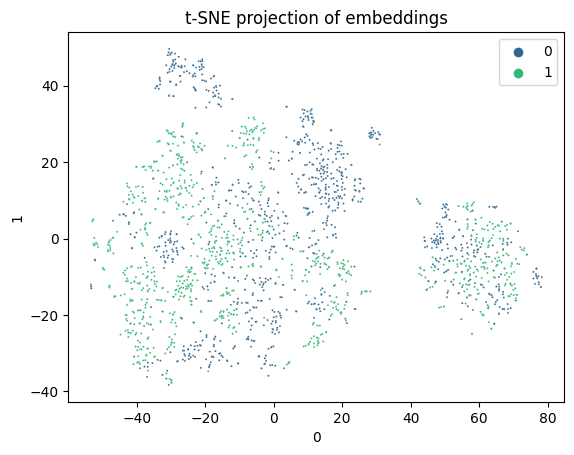

In [26]:
df = pd.concat([df_train, df_test])

sns.scatterplot(x=tsne_df[0], y=tsne_df[1], hue=df.label.tolist(),
                palette=sns.color_palette('viridis', 2),
                data=df, s=2).set(title='t-SNE projection of embeddings')